## Homework 4

#### Name: Priyam Mazumdar
#### NetID: priyamm2

In [1]:
### Load Packages ###
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from sklearn.metrics import mean_squared_error
import pandas as pd

In [2]:
# Generate Data
np.random.seed(542)
n = 150
x = np.random.uniform(low=0, high=1, size=(n, 1))
X = np.hstack([np.ones(shape=(150,1)), x])
args = np.array([0.5, 1])
y = X.dot(args) + np.random.standard_normal(150)
y[x.argmin()] = -30

### Problem 1
a) [5 pts] Fit an OLS model with the regular ℓ2
 loss. Report your coefficients (do not report other information). Although this is only one set of samples, but do you expect this estimator to be biased based on how we set up the observed data? Do you expect the parameter β1
 to bias upwards or downwards? Explain your reason. Hint: is the outlier pulling the regression line slope up or down?

In [3]:
def OLS(X, y):
    return np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
 
coefficients = OLS(X, y)
print("OLS Parameters B0:", coefficients[0], "B1:", coefficients[1])

OLS Parameters B0: -0.32252335404905885 B1: 2.199452488577025


The presence of this outlier will cause a major bias in our parameters and the regression model will poorly predict the training data. We can expect the outlier to bias our $\beta_1$ upwards. The reason for this is we set our minimum X as -30 which will force our leftside of the regression line downwards to minimize OLS. 


b) [10 pts] Define your own Huber loss function huberLoss(b, trainX, trainY) given a set of observed data with tuning parameter δ=1
. Here, b is a p
-dim parameter vector, trainX is a n×p
 design matrix and trainY
 is the outcome. This function should return a scalar as the empirical loss. You can use our Huber function in your own code. After defining this loss function, use the optim() function to solve the parameter estimates. Finally, report your coefficients.

In [4]:
class HuberLoss:
    def __init__(self, trainX, trainY):
        self.train_X = trainX
        self.train_y = trainY
        self.b_guess = [0,0]
        self.delta = 1
    
    def loss(self, b):
        b = np.array(b)
        diff = self.train_y - self.train_X.dot(b)
        # MSE Loss if less than delta
        diff[np.where(abs(diff)<=self.delta)] = 0.5*diff[np.where(abs(diff)<=self.delta)]**2
        # ABS Loss if greater than delta
        diff[np.where(abs(diff)>self.delta)] = self.delta*np.abs(diff[np.where(abs(diff)>self.delta)]) - self.delta/2

        return np.mean(diff)
    
    def optimize(self):
        result = optimize.minimize(self.loss, self.b_guess, method="BFGS")
        return result.x

HL = HuberLoss(X, y)
optimized_parameters = HL.optimize()
print("Optimizer Parameters B0:", optimized_parameters[0], "B1:", optimized_parameters[1])
print("Huber Loss from Optimize Parameters", HL.loss(optimized_parameters))



Optimizer Parameters B0: 0.42098531186094384 B1: 1.0660410224987118
Huber Loss from Optimize Parameters 0.5481708305815473


c) [20 pts] We still do not know which method performs better in this case. Let’s use a simulation study to compare the two methods. Complete the following

Set up a simulation for 1000 times. At each time, randomly generate a set of observed data, but also force the outlier with our code y[which.min(X[, 2])] = -30.
Fit the regression model with ℓ2 loss and Huber loss, and record the slope variable estimates.
Make a side-by-side boxplot to show how these two methods differ in terms of the estimations. Which method seem to have more bias? and report the amount of bias based on your simulation. What can you conclude from the results? Does this match your expectation in part a)? Can you explain this (both OLS and Huber) with the form of loss function, in terms of what their effects are?


In [5]:
def gen_data():
    n = 150
    x = np.random.uniform(low=0, high=1, size=(n, 1))
    X = np.hstack([np.ones(shape=(150,1)), x])
    args = np.array([0.5, 1])
    y = X.dot(args) + np.random.standard_normal(150)
    y[x.argmin()] = -30
    
    return X, y

ols = []
huber = []
for i in range(1000):
    X, y = gen_data()
    ### OLS Estimate ###
    ols_coeff = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    ols.append(list(ols_coeff))
    
    ### Huber Loss ###
    HL = HuberLoss(X, y)
    optimized_parameters = HL.optimize()
    huber.append(list(optimized_parameters))
    

In [6]:
### Calculate Bias
avg_b1_huber = np.array(huber).mean(axis=0)[1]
avg_b1_ols = np.array(ols).mean(axis=0)[1]
print("Bias of B1 from Huber: {}".format(avg_b1_huber - 1))
print("Bias of B1 from OLS: {}".format(avg_b1_ols - 1))

Bias of B1 from Huber: 0.06785150427398223
Bias of B1 from OLS: 1.2224467438278563


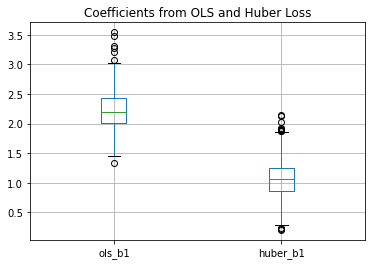

In [7]:
coeff_estimates = pd.DataFrame(np.hstack([np.array(ols)[:, 1].reshape(1000,1),np.array(huber)[:, 1].reshape(1000,1)]))
coeff_estimates.columns = ["ols_b1", "huber_b1"]
coeff_estimates.boxplot()
plt.title("Coefficients from OLS and Huber Loss")
plt.show()

We can clearly tell that our OLS Regression had much more bias than huber (Huber has a bias of 0.076 wherease OLS had a bias of 1.23 for our B1 term). We would expect our model intercept to be around 0.5 with a slope of 1, as we indicated in the toy model, and OLS greatly deviated from this, whereas Huber was much closer to our expectation. Therefore we can say that OLS is very sensitive to outliers. This behavior is also expected from our loss functions, as OLS would put a massive penalty on our outlier, making it a point of high leverage on the regression. Huber on the other hand is able to handle our outliers by not putting large penalties on them, therefore giving more reliable coefficients that are representative of the data.

### Problem 2

a) [10 pts] Fit an OLS estimator with the original data Y_org and X_org by lm(). Also, fit another OLS with scaled data by lm(). Report the coefficients/parameters. Then, transform coefficients from the second approach back to its original scale, and match with the first approach. Summarize your results in a single table: The rows should contain three methods: OLS, OLS Scaled, and OLS Recovered, and there should be four columns that represents the coefficients for each method. You can consider using the kable function, but it is not required.

In [8]:
### Generate Data ###
np.random.seed(10)
n = 20
p = 3

V = np.repeat(0.3, 9).reshape(3,3)
np.fill_diagonal(V, 1)

true_b = np.array([1, 2, 0])
X_org = np.random.multivariate_normal(np.repeat(0,3), V, size=n)
Y_org = X_org.dot(true_b) + np.random.standard_normal(size=20)

X_scaled = ((X_org - X_org.mean(axis=0)) / X_org.std(axis=0))
y_scaled  = ((Y_org - Y_org.mean(axis=0))/Y_org.std(axis=0))

# Least Squares of UnScaled Data
least_squared_unscsaled = LinearRegression().fit(X_org, Y_org)
least_squared_coef_unscaled= np.hstack([least_squared_unscsaled.intercept_, least_squared_unscsaled.coef_])
# # Least Squares of Scaled Data
least_squared_scaled = LinearRegression().fit(X_scaled, y_scaled)
least_squared_coef_scaled= np.hstack([least_squared_scaled.intercept_, least_squared_scaled.coef_])

# Recover original Coefficients
y_org_std = Y_org.std()
y_org_mu = Y_org.mean()

b0 = y_org_mu - sum([X_org[:, i].mean()*y_org_std*least_squared_coef_scaled[i+1]/X_org[:, i].std() 
                      for i in range(len(least_squared_coef_scaled)-1)])

b1, b2, b3 = [y_org_std*least_squared_coef_scaled[i+1]/X_org[:, i].std() 
                      for i in range(len(least_squared_coef_scaled)-1)] 

recovered_coef = [b0, b1, b2, b3]

coeff_table = np.array([list(least_squared_coef_unscaled), list(least_squared_coef_scaled), list(recovered_coef)])
coeff = pd.DataFrame(coeff_table).round(5)
coeff.columns = ["B0", "B1", "B2", "B3"]
coeff.index = ["Unscaled", "Scaled", "Recovered"]

display(coeff)

,B0,B1,B2,B3
Unscaled,0.13069,0.73809,2.47960,0.11529
Scaled,-0.00000,0.36418,0.77557,0.04084
Recovered,0.13069,0.73809,2.47960,0.11529


As we can see, we were able to fully recover the original coefficients on unscaled data by reconstructing the coefficients from our scaled data.

### Part B

**Coodinate Descent Derivation**

$$L(\beta) = \sum_{i=1}^n(y_i - \sum_{j=0}^pX_{ij}\beta_{j})^2$$

$$\frac{\partial L(\beta)}{\partial \beta_j} = -2\sum_{i=1}^n(y_i - \sum_{j=0}^pX_{ij}\beta_{j})x_{ij} = 0$$

$$-2\sum_{i=1}^n(y_i - x_{ij}\beta_j - \sum_{k\not=j}^px_{ik}\beta_{k})x_{ij} = 0$$

$$\beta_j = \frac{\sum_{i=1}^nx_{ij}(y_i - \sum_{k\not=j}^px_{ik}\beta_{k})}{\sum_{i=1}^nx_{ij}^2}$$

We can treat the term $(y_i - \sum_{k\not=j}^px_{ik}\beta_{k})$ as removing the effects of all other terms except for our target predictor j


### Part C

In [17]:
def coordinate_descent(X, y, iterations=100, tol=1e-7):
    n, p = X.shape
    curr_beta = [0 for i in range(p)]
    beta_list = [0,0,0]
    loss_list = []
    counter = 0
    while True:
        for j in range(p):
            x_wo_j = np.delete(X, j, axis=1)
            b_wo_j = np.delete(np.array(curr_beta), j)
            x_j = X[:, j]
            
            curr_beta[j] = (x_j@(y - x_wo_j@b_wo_j)) / (x_j.T@x_j)
            print((b_wo_j).shape)
            beta_list.append(curr_beta[j])
        counter += 1    
        loss_list.append(np.sum((y - X@curr_beta)**2))
        if (counter >= iterations): 
            break
            
        if abs(np.sum(np.array(beta_list)[-6:-3] - np.array(beta_list)[-3:])) < tol:
            print(f"Finished in {counter} Iterations")
            break
            

             
    beta_list = np.array(beta_list).reshape(-1,3)
        
    print("---Optimized Parameters---")
    print("B1:",round(beta_list[-1][0], 4), "B2:",round(beta_list[-1][1],4), "B3:", round(beta_list[-1][2], 4))
    print("Loss:", loss_list[-1])
    return beta_list, loss_list
        
        
betas, loss = coordinate_descent(X_scaled, y_scaled) 

(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
Finished in 9 Iterations
---Optimized Parameters---
B1: 0.3642 B2: 0.7756 B3: 0.0408
Loss: 2.795071565502311


We can see that our coordinate descent returned the exact values we recived from running OLS on our scaled data previously.

### Part D

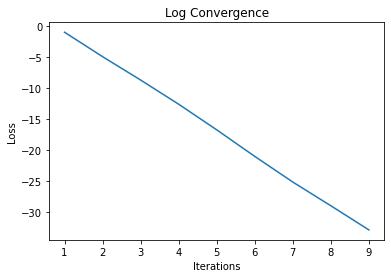

In [10]:
actual_loss = np.sum((y_scaled - least_squared_scaled.predict(X_scaled))**2)
convergence = [np.log(loss[i] - actual_loss) for i in range(len(loss))]
plt.plot(list(range(1, len(convergence)+1)), convergence)
plt.title("Log Convergence")
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.show()


We can see that our coordinate descent algorithm has a linear convergence rate.